In [2]:
import os
from collections import Counter, defaultdict

import h5py
import cv2
import scipy.cluster
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches

from vsim_common import load_vocabulary, descriptors_to_bow_vector, load_SIFT_file

%matplotlib notebook

In [3]:
DATASET_DIR = '/home/hannes/Datasets/narrative2/'

In [11]:
class VisualDatabase:
    def __init__(self, image_dict, vocabulary):
        self.vocabulary = vocabulary
        
        # Calculate inverse document frequency (IDF)
        # The number of documents that has at least one occurence of a word
        database_word_count = None
        for v in image_dict.values():
            if database_word_count is None:
                database_word_count = np.ones_like(v)            
            database_word_count += (v > 0)
            
        self._log_idf = np.log(len(image_dict) / database_word_count)
                
        self._word2image = defaultdict(list)
        self._image_words = {}
        
        for key, v in image_dict.items():
            tf = v.astype('float64') / np.sum(v)
            tfidf = tf * self._log_idf
            self._image_words[key] = tfidf / np.linalg.norm(tfidf)
            for i in np.flatnonzero(v):
                self._word2image[i].append(key)
    
    def query_vector(self, Vq, method='default'):        
        Vq = Vq.astype('float64')
        #tf = (Vq.astype('float64') / np.sum(Vq))
        if method == 'default':
            tf = Vq
        elif method == 'max':
            tf = 0.5 + 0.5 * Vq / Vq.max()
        else:
            raise ValueError("Uknown method '{}'".format(method))
        Vq_tfidf = tf * self._log_idf
        Vq_tfidf /= np.linalg.norm(Vq_tfidf)
        scores = [(key, np.dot(Vq_tfidf, Vdb)) for key, Vdb in self._image_words.items()]
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores
    
    def query_image(self, image, roi, method='default', sift_file=None):
        if sift_file:
            print('Loading SIFT features from', sift_file)
            des, kps = load_SIFT_file(sift_file)
        else:
            print('Detecting and calculating SIFT descriptors')
            detector = cv2.xfeatures2d.SIFT_create()
            kps, des = detector.detectAndCompute(image, None)
        
        def inside_roi(kp, roi):
            rx, ry, rw, rh = roi
            x, y = kp.pt
            return (rx <= x <= rx + rw) and (ry <= y <= ry + rh)            
        
        print('Found {} SIFT keypoints'.format(len(kps)))
        
        valid = [i for i, kp in enumerate(kps) if inside_roi(kp, roi)]        
        kps = [kp for i, kp in enumerate(kps) if i in valid]
        des = des[valid]
        
        print('Features in ROI:', len(kps))
        print('Calculating BOW vector')
        Vq = descriptors_to_bow_vector(des, self.vocabulary)
        
        return self.query_vector(Vq, method=method)
        
    
    @classmethod
    def from_files(cls, db_path, voc_path):
        with h5py.File(db_path, 'r') as f:
            db_dict = { key: f[key].value for key in f}
        vocabulary = load_vocabulary(voc_path)
        instance = cls(db_dict, vocabulary)
        return instance

db_file = 'db_sift_10k.h5'
voc_file = '/home/hannes/Datasets/narrative2/voc_sift_10k.h5'
db = VisualDatabase.from_files(db_file, voc_file)

In [18]:
matches = db.query_image(test_image, roi, sift_file=test_sift_file, method='max')

Loading SIFT features from /home/hannes/Datasets/narrative2/20161129_094114_000.sift.h5
Found 26375 SIFT keypoints
Features in ROI: 1164
Calculating BOW vector


In [14]:
with open(os.path.join(DATASET_DIR, 'labels.txt'), 'r') as f:
    label_dict = {}
    for line in f.readlines():
        filename, *labels = line.split()
        label_dict[filename] = labels

<IPython.core.display.Javascript object>


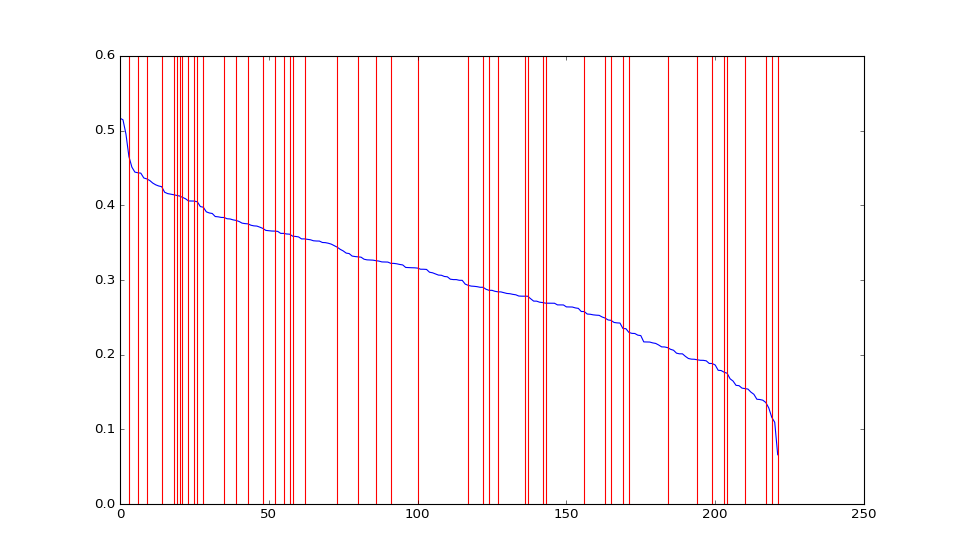

In [19]:
colors = ['r' if 'H' in label_dict[fname + '.jpg'] else 'k' for fname, score in matches]
plt.figure(figsize=(12, 7))
scores = [score for fname, score in matches]
plt.plot(np.arange(len(scores)), scores)
for i, (fname, score) in enumerate(matches):
    if 'H' in label_dict[fname + '.jpg']:
        plt.axvline(i, color='r')

<IPython.core.display.Javascript object>


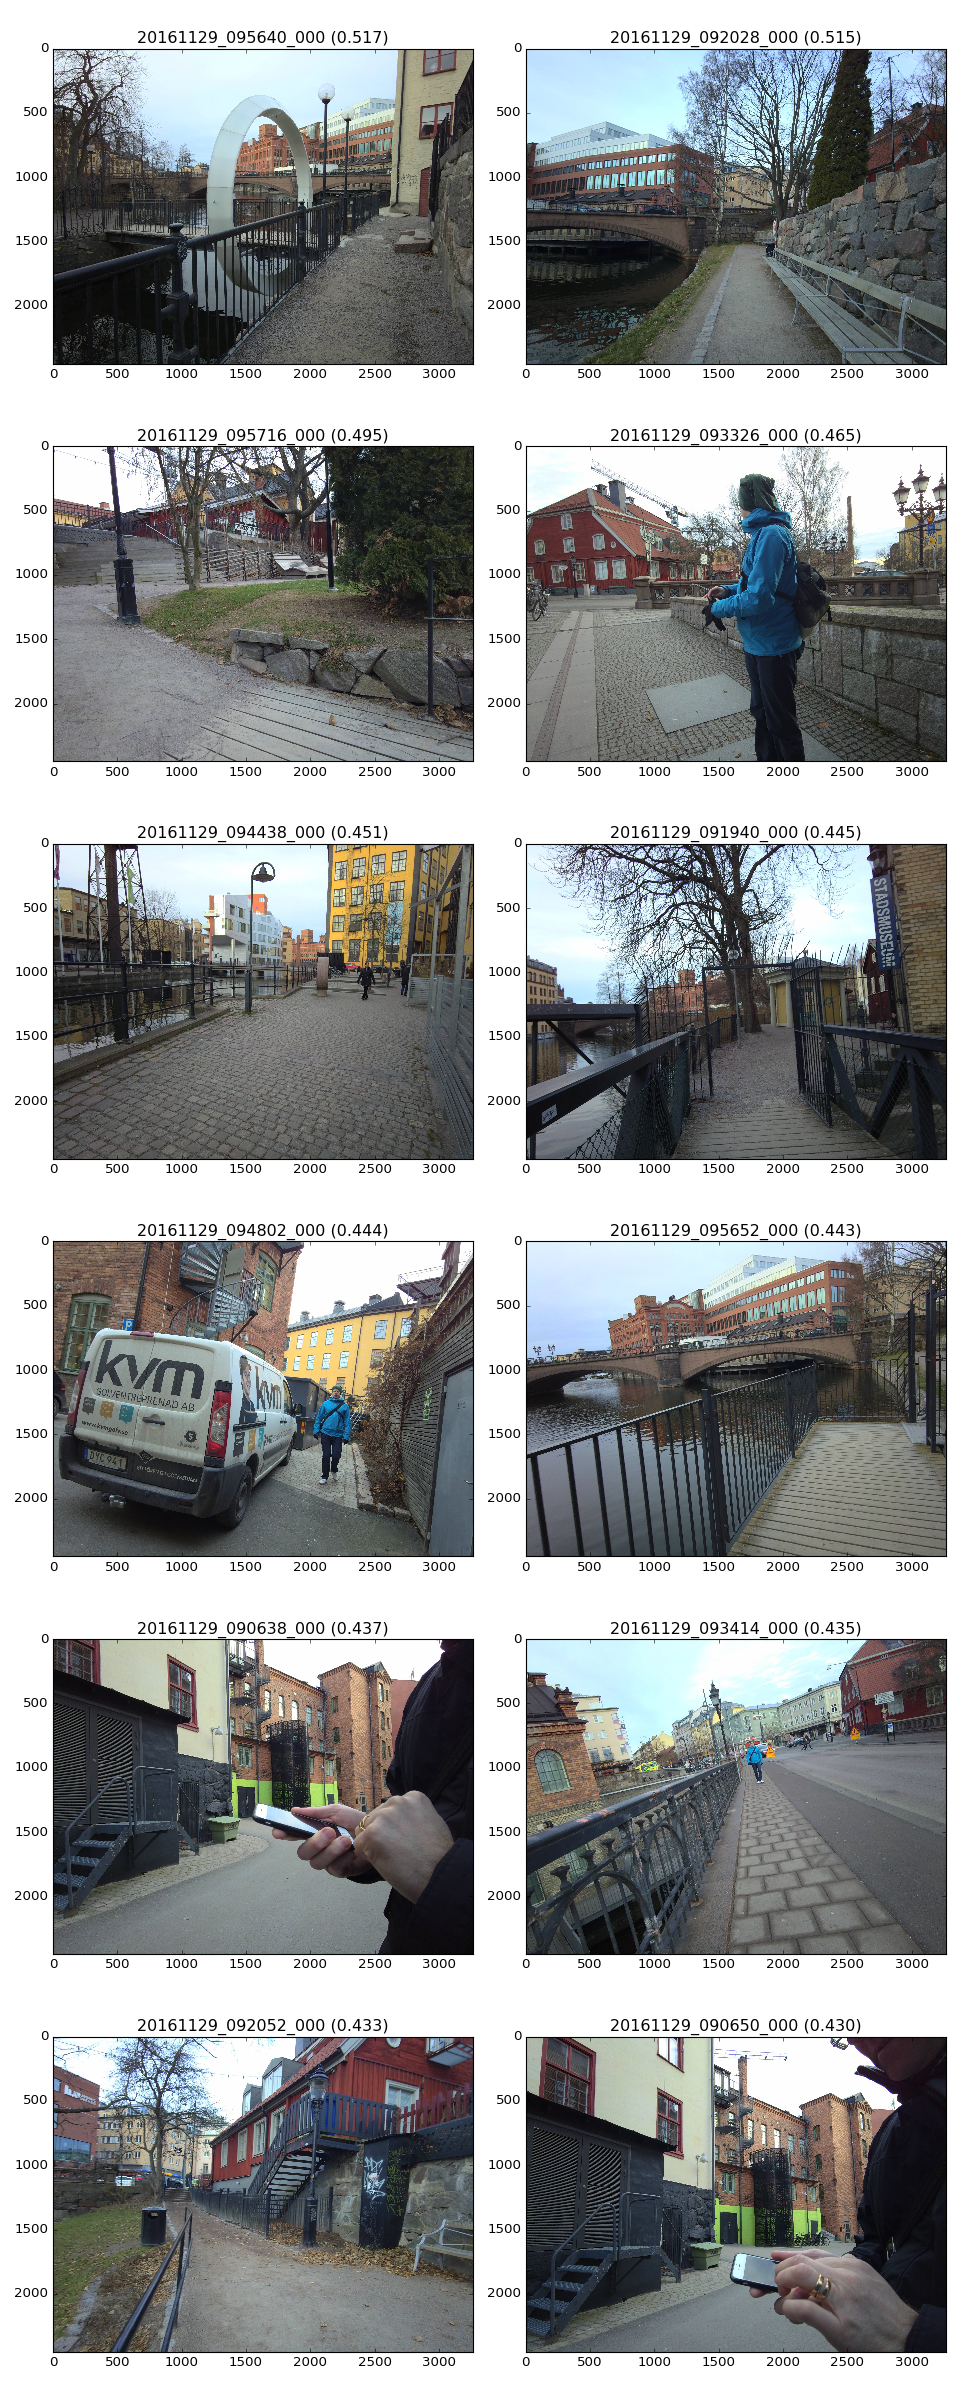

In [20]:
rows, cols = 6, 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
for ax, (fname, score) in zip(axes.flatten(), matches):
    image = plt.imread(os.path.join(DATASET_DIR, fname + '.jpg'))
    ax.imshow(image)
    ax.set_title("{} ({:.3f})".format(fname, score))
fig.tight_layout()

<IPython.core.display.Javascript object>


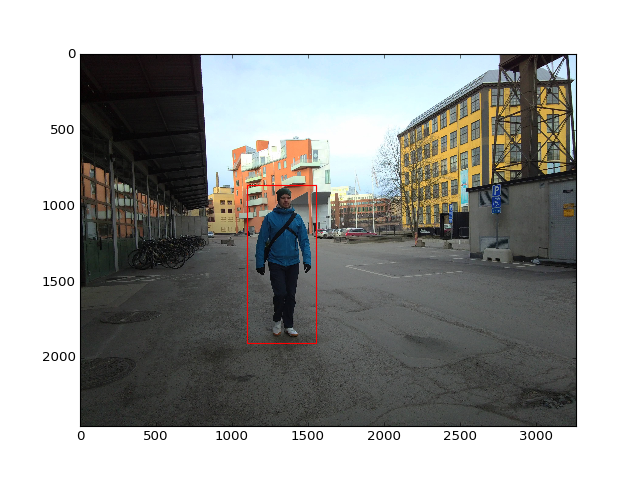

In [17]:
#test_filename = '/home/hannes/Datasets/narrative2/20161129_094450_000.jpg'
test_filename = '/home/hannes/Datasets/narrative2/20161129_094114_000.jpg'
test_sift_file = os.path.splitext(test_filename)[0] + '.sift.h5'
test_image = cv2.imread(test_filename)
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
rois = {'20161129_094450_000.jpg': [1515, 1200, 100, 250], # x, y, w, h
        '20161129_094114_000.jpg': [1100, 860, 450, 1040]}
roi = rois.get(os.path.split(test_filename)[-1], None)

if roi:
    rect = matplotlib.patches.Rectangle(roi[:2], roi[2], roi[3], facecolor='none', edgecolor='r')
    ax.add_patch(rect)


In [ ]:
1900 - 860

In [ ]:
with h5py.File(db_file, 'r') as f:
    Vq = f['20161129_090638_000'].value
    matches = db.query_vector(Vq)
    
matches[:5]